## Schordinger's Equation

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
%matplotlib inline
import time
import copy
import sympy
#plt.style.use('dark_background')

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = nn.Linear(2,20)
        self.hidden_layer2 = nn.Linear(20,20)
        self.hidden_layer3 = nn.Linear(20,20)
        self.hidden_layer4 = nn.Linear(20,20)
        self.hidden_layer5 = nn.Linear(20,20)
        self.hidden_layer6 = nn.Linear(20,20)
        self.hidden_layer7 = nn.Linear(20,20)
        self.hidden_layer8 = nn.Linear(20,20)
        self.output_layer = nn.Linear(20,2)

    def forward(self, t,x):
        inputs = torch.cat([x,t],axis=1)
        layer1_out = torch.sigmoid(self.hidden_layer1(inputs))
        layer2_out = torch.sigmoid(self.hidden_layer2(layer1_out))
        layer3_out = torch.sigmoid(self.hidden_layer3(layer2_out))
        layer4_out = torch.sigmoid(self.hidden_layer4(layer3_out))
        layer5_out = torch.sigmoid(self.hidden_layer5(layer4_out))
        layer6_out = torch.sigmoid(self.hidden_layer6(layer5_out))
        layer7_out = torch.sigmoid(self.hidden_layer7(layer6_out))
        layer8_out = torch.sigmoid(self.hidden_layer8(layer7_out))
        output = self.output_layer(layer8_out)
        return output
    
net = Net()
net = net.to(device)

In [3]:
def f_h(t,x, net):
    uv = net(t,x)
    u = uv[:,0]
    v = uv[:,1]
    h = torch.sqrt(u**2 + v**2)
    return h.reshape(-1,1)

def gradient(uv, x):
    u = uv[:,0].reshape(-1,1)
    v = uv[:,1].reshape(-1,1)
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    v_x = torch.autograd.grad(v.sum(), x, create_graph=True)[0]
    return u_x, v_x

def f(t, x, net):
    uv = net(t,x)
    u = uv[:,0].reshape(-1,1)
    v = uv[:,1].reshape(-1,1)
    
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]
    v_x = torch.autograd.grad(v.sum(), x, create_graph=True)[0]
    v_xx = torch.autograd.grad(v_x.sum(), x, create_graph=True)[0]
    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    v_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    
    h2 = u**2 + v**2
    f_u = u_t + 0.5*v_xx + h2*v
    f_v = v_t - 0.5*u_xx - h2*u
    
    return f_u, f_v


mse_cost_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters())

In [4]:
bc_size = 2000
pt_size = 2000

x_bc = np.random.uniform(low=-5.0, high=5.0, size=(bc_size,1))
x_bc[0][0] = -5.0
x_bc[-1][0] = 5.0
t_bc = np.random.uniform(low=0.0, high=np.pi/2, size=(bc_size,1))
t_bc[0][0] = 0.0
t_bc[-1][0] = np.pi/2
u_bc = 2*(np.cosh(x_bc)**(-1))

bc_x = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
bc_t = Variable(torch.from_numpy(t_bc).float(), requires_grad=True).to(device)
bc_u = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)


zeros_bc = np.zeros((bc_size,1))
fives_bc = 5*np.ones((bc_size,1))
neg_fives_bc = -5.*np.zeros((bc_size,1))

bc_all_zeros = Variable(torch.from_numpy(zeros_bc).float(), requires_grad=False).to(device)
bc_all_fives = Variable(torch.from_numpy(fives_bc).float(), requires_grad=True).to(device)
bc_all_neg_fives = Variable(torch.from_numpy(neg_fives_bc).float(), requires_grad=True).to(device)
    
zeros_pt = np.zeros((pt_size,1))   
pt_all_zeros = Variable(torch.from_numpy(zeros_pt).float(), requires_grad=False).to(device)

In [7]:
iterations = 1000
lowest_loss = 99999999.0
losses = []
start = time.time()


for epoch in range(iterations):
    optimizer.zero_grad()
    
    
    # Loss based on PDE
    x_pt = np.random.uniform(low=-5.0, high=5.0, size=(pt_size,1))
    t_pt = np.random.uniform(low=0.0, high=np.pi/2, size=(pt_size,1))
    pt_x_collocation = Variable(torch.from_numpy(x_pt).float(), requires_grad=True).to(device)
    pt_t_collocation = Variable(torch.from_numpy(t_pt).float(), requires_grad=True).to(device)
    
    f_u, f_v = f(pt_t_collocation, pt_x_collocation, net)
    mse_f_u = mse_cost_function(f_u, pt_all_zeros)
    mse_f_v = mse_cost_function(f_v, pt_all_zeros)
    
    
    # Loss based on boundary condition (2*sech(x))
    h_out = f_h(bc_all_zeros, bc_x, net)
    mse_0 = mse_cost_function(h_out, bc_u)
    
    
    # Loss based on boundary condition (h(5,-5))
    uv = net(bc_t, bc_all_neg_fives)
    u_x_neg_fives, v_x_neg_fives = gradient(uv, bc_all_neg_fives)
    u_neg_fives = uv[:,0].reshape(-1,1)
    v_neg_fives = uv[:,1].reshape(-1,1)
    
    uv = net(bc_t, bc_all_fives)
    u_x_fives, v_x_fives = gradient(uv, bc_all_fives)
    u_fives = uv[:,0].reshape(-1,1)
    v_fives = uv[:,1].reshape(-1,1)
    
    mse_h_u = mse_cost_function(u_neg_fives, u_fives)
    mse_h_v = mse_cost_function(v_neg_fives, v_fives)
    
    mse_h_x_u = mse_cost_function(u_x_neg_fives, u_x_fives)
    mse_h_x_v = mse_cost_function(v_x_neg_fives, v_x_fives)

    
    
    # Combining the loss functions
    loss = (mse_f_u + mse_f_v) + (mse_0) + (mse_h_u + mse_h_v) + (mse_h_x_u + mse_h_x_u)
    

    with torch.autograd.no_grad():
        if loss.data < lowest_loss:
            lowest_loss = loss.data
            best_copy = copy.deepcopy(net)
        losses.append(lowest_loss)
        #if lowest_loss <= .0001:
        #    break;
        if (epoch+1)%1000 == 0:
            print(epoch+1,"Training Loss:",loss.data)
            
    loss.backward() # This is for computing gradients using backward propagation
    optimizer.step() # This is equivalent to : theta_new = theta_old - alpha * derivative of J w.r.t theta
    
    
# Save Model
torch.save(best_copy.state_dict(), "schrodinger_model.pt")
print('Completed',epoch+1,'iterations in',round((time.time()-start)/60,0), 'minutes')
print('Model Loss:',lowest_loss,'\n')

xs = list(range(len(losses)))
ys = np.zeros((len(losses),1))
plt.plot(xs,ys)
plt.plot(xs,losses)
plt.show()

KeyboardInterrupt: 

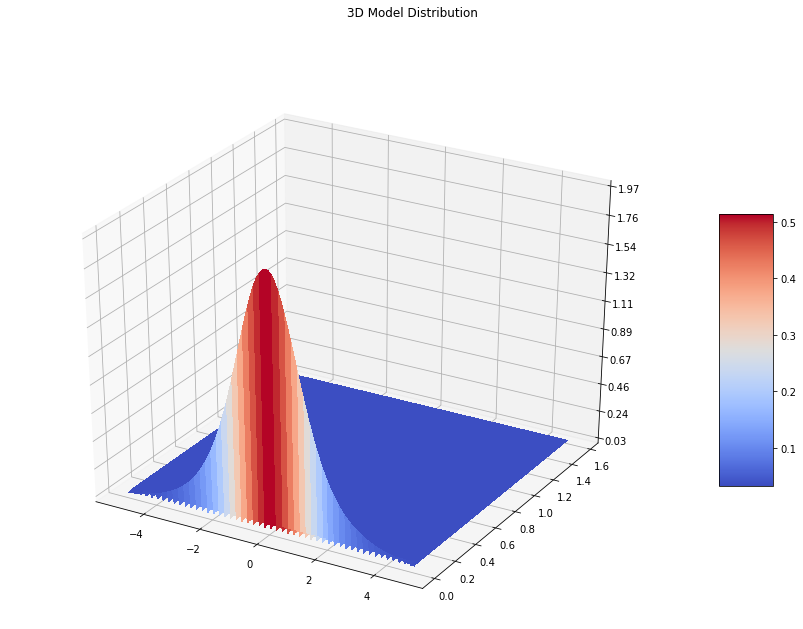

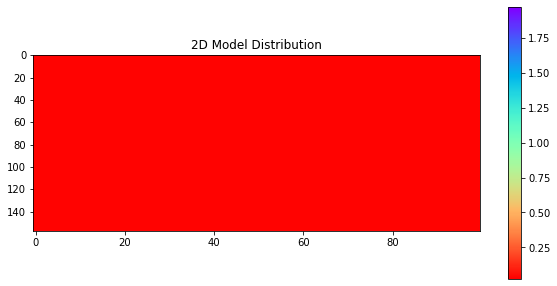

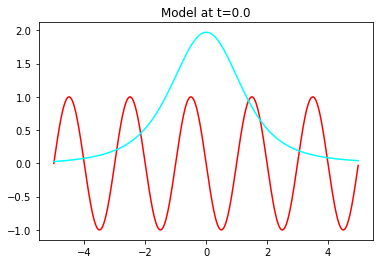

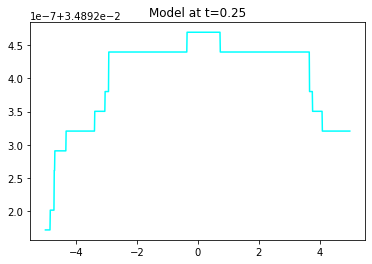

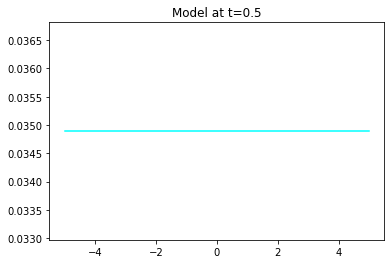

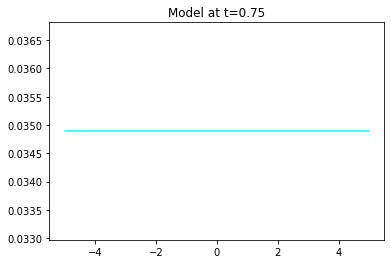

In [10]:
net = Net()
net.load_state_dict(torch.load('schrodinger_model.pt'))

def plot_3D_map(net):
    fig = plt.figure(figsize = (15,10))
    ax = fig.gca(projection='3d')
    fig.suptitle('3D Model Distribution')

    x=np.arange(-5,5,0.1)
    t=np.arange(0,np.pi/2,0.01)
    ms_x, ms_t = np.meshgrid(x, t)

    x = np.ravel(ms_x).reshape(-1,1)
    t = np.ravel(ms_t).reshape(-1,1)

    pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
    pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)
    pt_u = f_h(pt_t,pt_x,net)
    u=pt_u.data.cpu().numpy()
    ms_u = u.reshape(ms_x.shape)
    surf = ax.plot_surface(ms_x,ms_t,ms_u, cmap=cm.coolwarm,linewidth=0, antialiased=False)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.show()
    
def plot_heat_map(net):
    x=np.arange(-5,5,0.1)
    t=np.arange(0,np.pi/2,0.01)
    ms_x, ms_t = np.meshgrid(x, t)

    xx = np.ravel(ms_x).reshape(-1,1)
    tt = np.ravel(ms_t).reshape(-1,1)
    pt_x = Variable(torch.from_numpy(xx).float(), requires_grad=True).to(device)
    pt_t = Variable(torch.from_numpy(tt).float(), requires_grad=True).to(device)
    pt_u = f_h(pt_t,pt_x,net)
    
    u=pt_u.data.cpu().numpy()
    u = u.reshape(ms_x.shape)
    
    fig = plt.figure(figsize=(10,5))
    plt.imshow(u, cmap='rainbow_r', interpolation='nearest', aspect=.25)
    plt.title("2D Model Distribution")
    plt.colorbar()
    plt.show()
    
def plot_t_value(t_value, net):
    x=np.arange(-5,5,.01)
    xx=np.ravel(x).reshape(-1,1)
    t = np.ones((len(x),1))*t_value
    
    pt_x = Variable(torch.from_numpy(xx).float(), requires_grad=True).to(device)
    pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)
    pt_u = f_h(pt_t,pt_x,net)
    
    u=pt_u.data.cpu().numpy()
    
    if t_value == 0.0:
        ys = -np.sin(np.pi*x)
        plt.plot(x,ys,'r')
    plt.plot(x,u,'cyan')
    plt.title('Model at t='+str(t_value))
    plt.show()
    
plot_3D_map(net)
plot_heat_map(net)
plot_t_value(0.0,net)
plot_t_value(0.25,net)
plot_t_value(0.50,net)
plot_t_value(0.75,net)